Bobby Brady - Author

Purpose:

    Jupyter developed python code demoing training stable-baselines3 SAC, DDPG algorithms:
        1) Replay Buffer Size : [168,720,8760], batch_size = 24, learning_starts = 24
        2) Mini-batch size : [24,168,720], buffer_size = 8760, learning_starts = 24
        3) Learning starts : [24,168,720], batch_size = 24, buffer_size = 8760

### Import Libraries (may require local download/insatallation)

In [1]:
import gymnasium as gym
from gym.envs.registration import register
from gym import Env
from gym.spaces import Box
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from stable_baselines3 import DDPG, SAC, TD3, A2C
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common import env_checker
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
pd.options.mode.chained_assignment = None

### Data loading

In [2]:
mg_df = pd.DataFrame()

In [3]:
# Using observations instead of predictions for initial SAC,DDPG assesments

lmp_df = pd.read_csv('lmp_df.csv',delimiter='\t') # price per mWh
demand_df = pd.read_csv('2021_2022_community_demand_synth.csv',delimiter='\t') # community load
pv_df = pd.read_csv('2021_2022_PV_sim_PST_preprocessed.csv',delimiter='\t') # PV output to MG

mg_df['Obs_LMP'] = lmp_df['LMP']
mg_df['Obs_Load'] = demand_df['Load_w_noise']*.0001 # scaling down load to intended units mWh
mg_df['Obs_PV'] = pv_df['PV_kwAC_out']
#mg_df

In [4]:
# train, validation split

train_df = mg_df[:12265]
val_df = mg_df[12265:].reset_index()

### Environment

In [5]:
# Gym custom environment for microgrid (MG)

class MicroGridEnv(Env):
    def __init__(self,test=False):

        # desired self.action_space = Box(low=-10,high=15,shape=(1,))
        # stable baselines 3 recommends [-1,1] scale, float32 for stability, scale action in step function
        self.action_space = Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_space = Box(low=np.array([mg_df['Obs_LMP'].min(),mg_df['Obs_Load'].min(),mg_df['Obs_PV'].min(),0]),
                                     high=np.array([mg_df['Obs_LMP'].max(),mg_df['Obs_Load'].max(),mg_df['Obs_PV'].max(),200]),
                                     dtype=np.float64)
        
        if test:
            self.data_df = train_df[['Obs_LMP','Obs_Load','Obs_PV']] # if training
        else:
            self.data_df = val_df[['Obs_LMP','Obs_Load','Obs_PV']] # if validating
        self.data_df['Obs_Charge'] = 0 # ESS initially empty
        self.curr_index = 0
        self.data_len = self.data_df.shape[0]
        self.action = 0
        
    def step(self, action):
        done = False
        charge = 0
        lmp =  self.data_df['Obs_LMP'][self.curr_index]
        demand = self.data_df['Obs_Load'][self.curr_index]
        pv_out = self.data_df['Obs_PV'][self.curr_index]
        try:
            charge_prev = self.data_df['Obs_Charge'][self.curr_index-1] # get current ESS storage from last observation
        except:
            charge_prev = 0
        
        if (charge_prev + action < 0) : # ESS cannot have negative storage
            charge = 0
        elif (action > 0):
            charge += action*15 # scale ESS discharge to 15 mWh max (good reward)
        else:
            charge += action*10 # scale ESS charge to 10 mWh max (bad reward)
        self.data_df['Obs_Charge'][self.curr_index] = charge # tracking ESS storage
        
        reward = float(-(demand-charge)*lmp) # maximizing reward, flip sign
        
        observation = self.data_df.loc[self.curr_index].values
        
        if self.curr_index == self.data_len - 1: # Done if last data instance
            done = True
        self.curr_index += 1
        self.action = action
        
        info = {'Observations':observation,'SOC%':charge/200*100}
        
        return observation,reward,done,info
        
    def render(self):
        pass
    
    def reset(self):
        self.curr_index = 0
        self.data_df.Obs_Charge = 0
        return self.data_df.loc[self.curr_index].values

In [6]:
try:
    test_env.close()
    val_env.close()
except:
    pass

test_env = MicroGridEnv(test=True)
val_env = MicroGridEnv()

In [7]:
n_actions = test_env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

In [8]:
env_checker.check_env(test_env)

In [9]:
env_checker.check_env(val_env)

In [10]:
def all_reward(env,model):
    all_reward = []
    obs = env.reset()
    #obs = env.data_df.loc[12264].values
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, _info = env.step(action)
        all_reward.append(reward)
    env.close() # clean up env resources
    return all_reward

In [11]:
tot_reward_SAC_val = []
tot_reward_DDPG_val = []

### Visualization

In [12]:
def collect_rewards(buffer_size = 168, batch_size = 24, learning_starts=24):
    sac = SAC("MlpPolicy", 
              test_env, 
              learning_rate=0.001, 
              buffer_size=buffer_size, 
              batch_size=batch_size, 
              learning_starts=learning_starts, 
              verbose=1)
    sac.learn(total_timesteps=12264, log_interval=4)
    ddpg = DDPG("MlpPolicy", 
                test_env, 
                learning_rate=0.0000002, 
                buffer_size=buffer_size, 
                batch_size=batch_size, 
                learning_starts=learning_starts, 
                action_noise=action_noise, 
                verbose=1)
    ddpg.learn(total_timesteps=12264, log_interval=10)
    
    all_reward_SAC_test = all_reward(test_env,sac)
    test_env.close()
    all_reward_SAC_val =  all_reward(val_env,sac)
    test_env.close()
    del sac
    all_reward_DDPG_test =  all_reward(test_env,ddpg)
    val_env.close()
    all_reward_DDPG_val =  all_reward(val_env,ddpg)
    val_env.close()
    del ddpg
    
    return all_reward_SAC_test,all_reward_SAC_val,all_reward_DDPG_test,all_reward_DDPG_val

In [13]:
def running_total_reward(all_reward): 
    return np.cumsum([-x for x in all_reward])

In [14]:
def running_total_loss(all_reward): 
    return np.array([x for x in all_reward])

In [15]:
def visualize_loss(run_tot_loss_DDPG,run_tot_loss_SAC,size,axs,row,col):
    
    i = list(range(len(run_tot_loss_DDPG)))
    #run_tot_rewards_ddpg_test = np.array([x for x in run_tot_loss_DDPG])

    axs[row,col].plot(i,run_tot_loss_SAC, label='SAC Loss',color='Blue')
    axs[row,col].plot(i,run_tot_loss_DDPG, label='DDPG Loss',color='Orange')

    axs[row,col].hlines(y=0,xmin=0, xmax=12264,colors='Red')
    #axs[row,col].label_outer()
    #plt.scatter(i,run_tot_full, label='Full')
    axs[row,col].legend(loc=4,fontsize='xx-small')
    axs[row,col].set_title(f'Train Loss - {size}')

In [16]:
def visualize_learning(run_tot_rewards_DDPG,run_tot_rewards_SAC,run_tot_full,axs,row,col):
    i = list(range(len(run_tot_rewards_DDPG)))
    axs[row,col].plot(i,run_tot_full, label='FULL',color='Red')
    axs[row,col].plot(i,run_tot_rewards_DDPG, label='DDPG',color='Orange')
    axs[row,col].plot(i,run_tot_rewards_SAC, label='SAC',color='Blue')
    axs[row,col].hlines(y=run_tot_full[-1],
                           xmin=0, 
                           xmax=5200,
                           colors='Red', 
                           linestyles='dashed',
                           #label=str(int(np.round(run_tot_full[-1])))
                       )
    axs[row,col].hlines(y=run_tot_rewards_DDPG[-1],
                           xmin=0, 
                           xmax=5200,
                           colors='Orange', 
                           linestyles='dashed',
                           #label=str(int(np.round(run_tot_rewards_DDPG[-1])))
                       )
    axs[row,col].hlines(y=run_tot_rewards_SAC[-1],
                           xmin=0, 
                           xmax=5200,
                           colors='Blue', 
                           linestyles='dashed',
                           #label=str(int(np.round(run_tot_rewards_SAC[-1])))
                       )
    #axs[row,col].label_outer()
    axs[row,col].legend(loc=4,fontsize='xx-small')
    axs[row,col].set_title(f'Val Reward')

In [17]:
run_tot_full = np.cumsum([y[0]*y[1] for y in mg_df[['Obs_LMP','Obs_Load']][12265:].values])

### 1) Replay Buffer Size

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


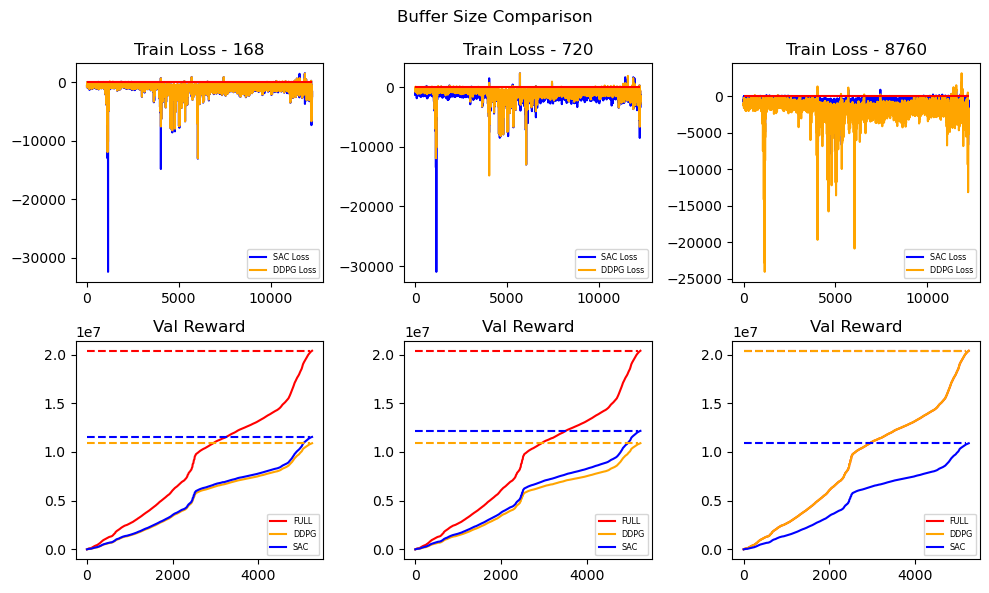

In [18]:
buffer_list = [168,720,8760]
batch_size = 24
learning_starts = 24

fig, axs = plt.subplots(2,3,figsize=(10, 6))
fig.suptitle('Buffer Size Comparison', fontsize='large')
row = 0
col = 0

for buffer_size in buffer_list:
    all_reward_SAC_test,all_reward_SAC_val,all_reward_DDPG_test,all_reward_DDPG_val = collect_rewards(buffer_size,
                                                                                                      batch_size,
                                                                                                      learning_starts)
    run_tot_loss_SAC_test = running_total_loss(all_reward_SAC_test)
    run_tot_loss_DDPG_test = running_total_loss(all_reward_DDPG_test)
    run_tot_rewards_SAC_val = running_total_reward(all_reward_SAC_val)
    run_tot_rewards_DDPG_val = running_total_reward(all_reward_DDPG_val)
    
    visualize_loss(run_tot_loss_DDPG_test,run_tot_loss_SAC_test,buffer_size,axs,row,col)
    row += 1
    visualize_learning(run_tot_rewards_DDPG_val,run_tot_rewards_SAC_val,run_tot_full,axs,row,col)
    row -= 1
    col += 1
plt.tight_layout()
plt.show()

### 2) Mini Batch Size

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


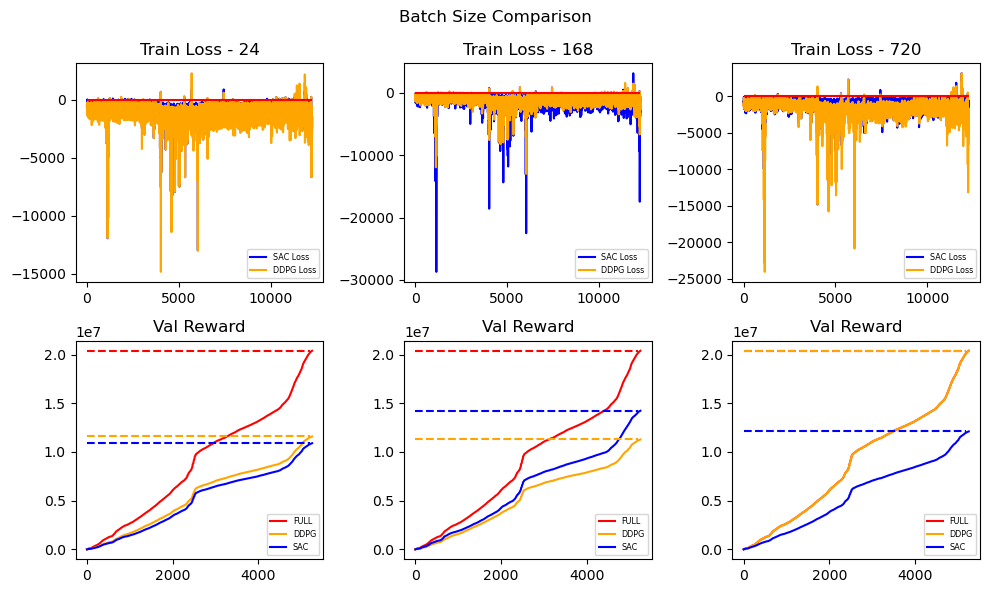

In [19]:
buffer_size = 8760
batch_list = [24,168,720]
learning_starts = 24

fig, axs1 = plt.subplots(2,3,figsize=(10, 6))
fig.suptitle('Batch Size Comparison', fontsize='large')
row = 0
col = 0

for batch_size in batch_list:
    all_reward_SAC_test,all_reward_SAC_val,all_reward_DDPG_test,all_reward_DDPG_val = collect_rewards(buffer_size,
                                                                                                      batch_size,
                                                                                                      learning_starts)
    run_tot_loss_SAC_test = running_total_loss(all_reward_SAC_test)
    run_tot_loss_DDPG_test = running_total_loss(all_reward_DDPG_test)
    run_tot_rewards_SAC_val = running_total_reward(all_reward_SAC_val)
    run_tot_rewards_DDPG_val = running_total_reward(all_reward_DDPG_val)
    
    visualize_loss(run_tot_loss_DDPG_test,run_tot_loss_SAC_test,batch_size,axs1,row,col)
    row += 1
    visualize_learning(run_tot_rewards_DDPG_val,run_tot_rewards_SAC_val,run_tot_full,axs1,row,col)
    row -= 1
    col += 1
plt.tight_layout()
plt.show()

### 3) Learning Starts

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


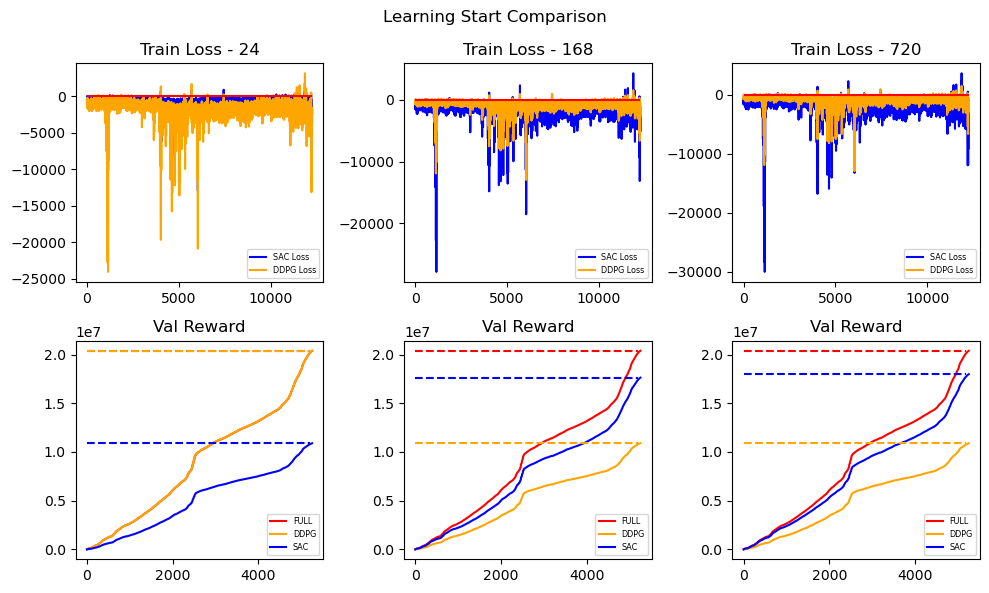

In [22]:
buffer_size = 8760
batch_size = 24
learning_starts_list = [24,168,720]

fig, axs2 = plt.subplots(2,3,figsize=(10, 6))
fig.suptitle('Learning Start Comparison', fontsize='large')
row = 0
col = 0

for learning_starts in learning_starts_list:
    all_reward_SAC_test,all_reward_SAC_val,all_reward_DDPG_test,all_reward_DDPG_val = collect_rewards(buffer_size,
                                                                                                      batch_size,
                                                                                                      learning_starts)
    run_tot_loss_SAC_test = running_total_loss(all_reward_SAC_test)
    run_tot_loss_DDPG_test = running_total_loss(all_reward_DDPG_test)
    run_tot_rewards_SAC_val = running_total_reward(all_reward_SAC_val)
    run_tot_rewards_DDPG_val = running_total_reward(all_reward_DDPG_val)
    
    visualize_loss(run_tot_loss_DDPG_test,run_tot_loss_SAC_test,learning_starts,axs2,row,col)
    row += 1
    visualize_learning(run_tot_rewards_DDPG_val,run_tot_rewards_SAC_val,run_tot_full,axs2,row,col)
    row -= 1
    col += 1
plt.tight_layout()
plt.show()